# Imports 

In [1]:
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Flatten
from keras.layers.convolutional import Conv3D, MaxPooling3D, ZeroPadding3D
import numpy as np 
import os 
from keras.layers.wrappers import TimeDistributed
from keras.layers.convolutional import (Conv2D, MaxPooling3D, Conv3D,MaxPooling2D)
import cv2
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical 
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import ModelCheckpoint
from keras.layers.recurrent import LSTM
import keras 

Using TensorFlow backend.


In [2]:
!pip uninstall -y kaggle 
!pip install kaggle==1.5.6
%env KAGGLE_USERNAME =thesniper
%env KAGGLE_KEY =f5a849dfb011d6d68a526d96bdac49a3

Uninstalling kaggle-1.5.6:
  Successfully uninstalled kaggle-1.5.6
Processing /root/.cache/pip/wheels/57/4e/e8/bb28d035162fb8f17f8ca5d42c3230e284c6aa565b42b72674/kaggle-1.5.6-cp36-none-any.whl
env: KAGGLE_USERNAME=thesniper
env: KAGGLE_KEY=f5a849dfb011d6d68a526d96bdac49a3


In [3]:
from google.colab import drive 
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Create Model  


In [0]:
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.models import load_model
def create_model_sequential():
    model = VGG16(weights='imagenet')
    return model

def create_features_exctractor(model, layer_name='fc2'):
    extractor = Model(inputs=model.input,
                      outputs=model.get_layer(layer_name).output)
    return extractor

In [37]:
model = create_model_sequential()
print(model.summary())
model = create_features_exctractor(model)

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [0]:
input_layer = keras.Input(batch_shape=(1,30,224,224,3))
h2 = keras.layers.wrappers.TimeDistributed(model)(input_layer)
x  = TimeDistributed(Flatten())(h2)
x = Dropout(0.5)(x)
x = LSTM(256, return_sequences=False, dropout=0.5)(x)
x = Dense(5, activation='softmax')(x)
model = keras.Model(input_layer,x)

In [7]:
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (1, 30, 224, 224, 3)      0         
_________________________________________________________________
time_distributed_1 (TimeDist (1, 30, 4096)             134260544 
_________________________________________________________________
time_distributed_2 (TimeDist (1, 30, 4096)             0         
_________________________________________________________________
dropout_1 (Dropout)          (1, 30, 4096)             0         
_________________________________________________________________
lstm_1 (LSTM)                (1, 256)                  4457472   
_________________________________________________________________
dense_1 (Dense)              (1, 5)                    1285      
Total params: 138,719,301
Trainable params: 138,719,301
Non-trainable params: 0
_____________________________________________

# Test For Model

In [0]:
for layer in model.layers:
    layer.trainable = False

model.layers[-1].trainable = True
model.layers[-2].trainable = True 

In [9]:
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (1, 30, 224, 224, 3)      0         
_________________________________________________________________
time_distributed_1 (TimeDist (1, 30, 4096)             134260544 
_________________________________________________________________
time_distributed_2 (TimeDist (1, 30, 4096)             0         
_________________________________________________________________
dropout_1 (Dropout)          (1, 30, 4096)             0         
_________________________________________________________________
lstm_1 (LSTM)                (1, 256)                  4457472   
_________________________________________________________________
dense_1 (Dense)              (1, 5)                    1285      
Total params: 138,719,301
Trainable params: 4,458,757
Non-trainable params: 134,260,544
_____________________________________

In [0]:
map = {
	'Diving' :	0,
	'Jumping' :	1,
	'Basketball':	2,
	'Tennis':	3,
	'Walking':	4}
classes = ['Diving',
	'Jumping',
	'Basketball',
	'Tennis',
	'Walking']

In [11]:
path = '/content/gdrive/My Drive/vision project/Training'
data=[]
labels=[]
for folder in os.listdir(path):
    print(folder)
    ctr0 = 0 
    ctr1 = 0 
    for video in os.listdir(os.path.join(path,folder)):
        frames=[]
        cap=cv2.VideoCapture(path+'/'+folder+'/'+video)
        length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        while(True):
              ret, frame = cap.read()
              if frame is None : 
                 break
              frame=cv2.resize(frame,(224,224))
              frames.append(frame)
        for i in range(0,np.shape(frames)[0],30):
           if i+30 < np.shape(frames)[0]:
              data.append(frames[i:i+30])
              labels.append(map[folder])
    print(np.shape(data))       


Basketball
(356, 30, 224, 224, 3)
Tennis
(882, 30, 224, 224, 3)
Diving
(1470, 30, 224, 224, 3)
Jumping
(2095, 30, 224, 224, 3)
Walking
(2546, 30, 224, 224, 3)


In [0]:
labels = np.reshape(labels,(np.shape(labels)[0],1))
data = np.array(data)

In [25]:
np.shape(X_test)

(255, 30, 224, 224, 3)

In [0]:
X_train,X_test,y_train,y_test = train_test_split(data,labels,test_size=0.1,stratify=labels,random_state=42,shuffle=True)

In [0]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [15]:
y_train[0]

array([0., 0., 1., 0., 0.], dtype=float32)

In [0]:
checkpoint = ModelCheckpoint("best_model_cnnlstm.hdf5", monitor='loss', verbose=1,
    save_best_only=True, mode='auto', period=1)
reduce_learning_rate = ReduceLROnPlateau(monitor='loss',
                                         factor=0.1,
                                         patience=2,
                                         cooldown=2,
                                         min_lr=0.00001,
                                         verbose=1)
callbacks=reduce_learning_rate

In [17]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs = 4 , batch_size=1 , shuffle=True, callbacks=[callbacks,checkpoint])

Train on 2291 samples, validate on 255 samples
Epoch 1/4
2291/2291 [==============================] - 2003s 874ms/step - loss: 0.2390 - accuracy: 0.9223 - val_loss: 0.1085 - val_accuracy: 0.9608

Epoch 00001: loss improved from inf to 0.23904, saving model to best_model_cnnlstm.hdf5
Epoch 2/4
2291/2291 [==============================] - 1997s 872ms/step - loss: 0.0828 - accuracy: 0.9769 - val_loss: 0.0527 - val_accuracy: 0.9843

Epoch 00002: loss improved from 0.23904 to 0.08283, saving model to best_model_cnnlstm.hdf5
Epoch 3/4
2291/2291 [==============================] - 1996s 871ms/step - loss: 0.0402 - accuracy: 0.9873 - val_loss: 0.0659 - val_accuracy: 0.9725

Epoch 00003: loss improved from 0.08283 to 0.04020, saving model to best_model_cnnlstm.hdf5
Epoch 4/4
2291/2291 [==============================] - 1997s 872ms/step - loss: 0.0266 - accuracy: 0.9908 - val_loss: 0.0126 - val_accuracy: 0.9961

Epoch 00004: loss improved from 0.04020 to 0.02657, saving model to best_model_cnnlst

# Confusion Matrix 

            Diving  Jumping  Basketball  Tennis  Walking
Diving          59        0           0       0        0
Jumping          0       62           0       0        0
Basketball       0        0          36       0        0
Tennis           0        0           0      53        0
Walking          0        1           0       0       44


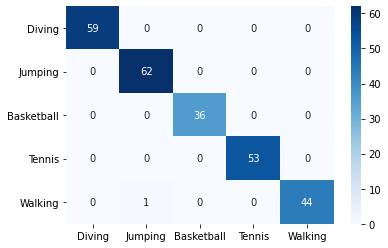

In [27]:
from sklearn.metrics import confusion_matrix,plot_confusion_matrix
import seaborn as sn
y_pred = []
for item in X_test : 
    y_ = model.predict(np.reshape(item,(1,30,224,224,3)))
    y_pred.append(np.argmax(y_,axis=1))
y_pred = np.array(y_pred)
cm =confusion_matrix(np.argmax(y_test,axis=1), y_pred).tolist()
cm =  pd.DataFrame(cm, index=classes, columns=classes)
print(cm)
ax = sn.heatmap(cm, cmap='Blues', annot=True,fmt="d")

In [0]:
# Free some space 
X_train = [] 
X_test = [] 
y_train = [] 
y_test = [] 
y_pred = [] 

In [29]:
model.fit(data,to_categorical(labels),batch_size=1,epochs = 2 , shuffle=True)

Epoch 1/2
2546/2546 [==============================] - 2006s 788ms/step - loss: 0.0222 - accuracy: 0.9949
Epoch 2/2
2546/2546 [==============================] - 2005s 787ms/step - loss: 0.0149 - accuracy: 0.9957


In [0]:
# Free some space 
data = [] 
labels = [] 

In [32]:
test_path = '/content/gdrive/My Drive/vision project/Testing'
lab =[]
names=[]
for video in os.listdir(test_path):
        frames=[]
        cap=cv2.VideoCapture(test_path+'/'+video)
        length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        while(True):
              ret, frame = cap.read()
              if frame is None : 
                 break
              frame=cv2.resize(frame,(224,224))
              frames.append(frame)
        prds = np.zeros((5,1))
        for i in range(0,np.shape(frames)[0],30):
           if i+30 < np.shape(frames)[0]:
             prd = model.predict(np.reshape(frames[i:i+30],(1,30,224,224,3)))
             prd = np.argmax(prd)
             prds[prd]+=1
        print(np.argmax(prds))
        print(video)
        lab.append(np.argmax(prds))
        names.append(video)
              
        

3
test_image (88).mpg
3
test_image (89).mpg
3
test_image (90).mpg
3
test_image (91).mpg
3
test_image (92).mpg
3
test_image (93).mpg
3
test_image (94).mpg
3
test_image (95).mpg
3
test_image (97).mpg
3
test_image (98).mpg
3
test_image (96).mpg
3
test_image (100).mpg
3
test_image (99).mpg
3
test_image (101).mpg
3
test_image (103).mpg
3
test_image (102).mpg
3
test_image (105).mpg
3
test_image (104).mpg
3
test_image (106).mpg
3
test_image (87).mpg
1
test_image (33).mpg
1
test_image (34).mpg
1
test_image (35).mpg
1
test_image (36).mpg
1
test_image (37).mpg
1
test_image (38).mpg
1
test_image (39).mpg
1
test_image (40).mpg
1
test_image (41).mpg
1
test_image (44).mpg
1
test_image (43).mpg
1
test_image (42).mpg
1
test_image (46).mpg
1
test_image (45).mpg
1
test_image (47).mpg
1
test_image (48).mpg
1
test_image (49).mpg
1
test_image (32).mpg
1
test_image (51).mpg
1
test_image (50).mpg
4
test_image (108).mpg
4
test_image (109).mpg
4
test_image (110).mpg
4
test_image (111).mpg
4
test_image (112).mp

In [0]:
df = pd.DataFrame(list(zip(names, lab)), 
               columns =['Video', 'Label']) 

In [34]:
df.to_csv('submission.csv',index=False)
!kaggle competitions submit computervisioncompetitionsc2020 -f "submission.csv" -m "vgg+lstm"

100% 2.74k/2.74k [00:00<00:00, 8.92kB/s]
Successfully submitted to Computer Vision Competition [SC-2020]

In [0]:
model.save('/content/gdrive/My Drive/vision project/submission3.h5')